In [34]:

!pip install wordcloud

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [36]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv to NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv


show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-13     80 min   
4    January 1, 2020          2008  PG-13    123 min   

                                           listed_in  \
0  International TV Shows, TV Dramas, TV Sci-Fi &...   
1                       Dramas, International Movies   
2                Horror Movies, International Movies   
3  Action & Adventure, Independent Movies, Sci-Fi...   
4                                             Dramas   

                                         description  
0  In a future where the elite inhabit an island ...  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...  
3  In a postapocalyptic world, rag-doll robots hi...  
4  A brilliant group of students become card-coun...

In [37]:
print("Shape:", df.shape)
df.info()
df.isnull().sum()


Shape: (7787, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [38]:
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['rating'].fillna('Unknown', inplace=True)

# Drop rows with missing description
df.dropna(subset=['description'], inplace=True)

# Convert to lowercase
text_cols = ['title', 'director', 'cast', 'listed_in', 'description']
for col in text_cols:
    df[col] = df[col].str.lower()


In [39]:
df['combined_features'] = (
df['description'] + " " +
df['listed_in'] + " " +
df['director'] + " " +
df['cast']
)

df[['title','combined_features']].head()

title                                  combined_features
0     3%  in a future where the elite inhabit an island ...
1   7:19  after a devastating earthquake hits mexico cit...
2  23:59  when an army recruit is found dead, his fellow...
3      9  in a postapocalyptic world, rag-doll robots hi...
4     21  a brilliant group of students become card-coun...

In [40]:
tfidf = TfidfVectorizer(
stop_words='english',
max_features=5000
)

X = tfidf.fit_transform(df['combined_features'])
print("TF-IDF Shape:", X.shape)


TF-IDF Shape: (7787, 5000)


In [41]:

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

print("Reduced Shape:", X_reduced.shape)


Reduced Shape: (7787, 100)


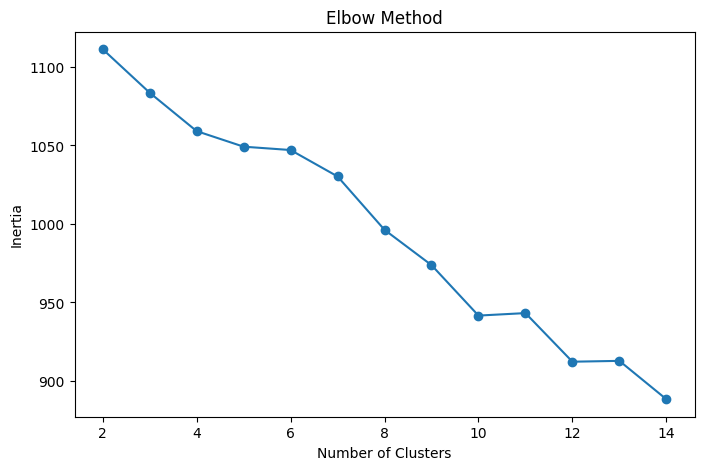

In [42]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_reduced)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [43]:

kmeans = KMeans(n_clusters=8, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(X_reduced)

df[['title','cluster_kmeans']].head()

title  cluster_kmeans
0     3%               1
1   7:19               0
2  23:59               0
3      9               2
4     21               3

In [44]:
agg = AgglomerativeClustering(n_clusters=8)
df['cluster_agg'] = agg.fit_predict(X_reduced)

In [45]:

print("KMeans Silhouette:", silhouette_score(X_reduced, df['cluster_kmeans']))
print("KMeans Calinski:", calinski_harabasz_score(X_reduced, df['cluster_kmeans']))
print("KMeans Davies:", davies_bouldin_score(X_reduced, df['cluster_kmeans']))

KMeans Silhouette: 0.05300396051940084
KMeans Calinski: 230.776773270756
KMeans Davies: 3.6419032435673993


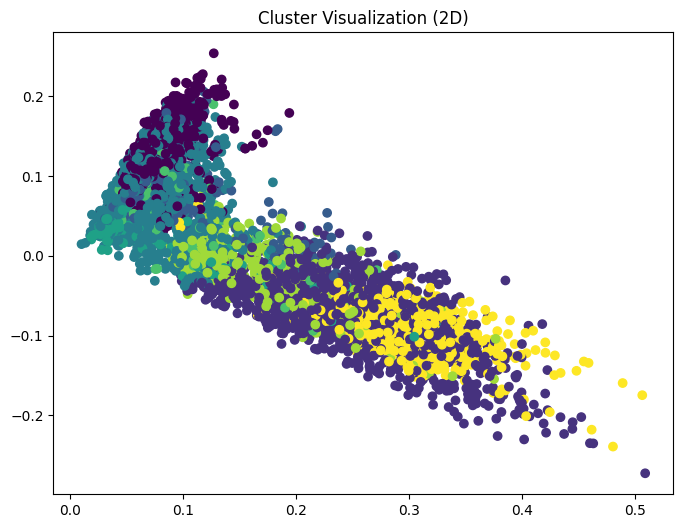

In [46]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_vis = svd_2d.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=df['cluster_kmeans'], cmap='viridis')
plt.title("Cluster Visualization (2D)")
plt.show()

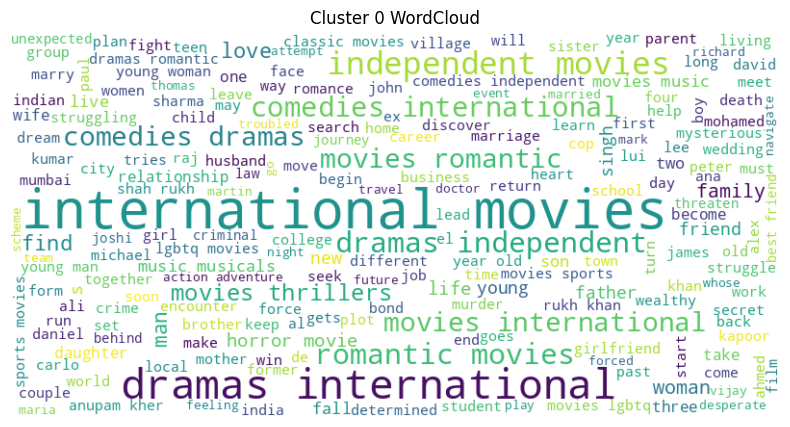

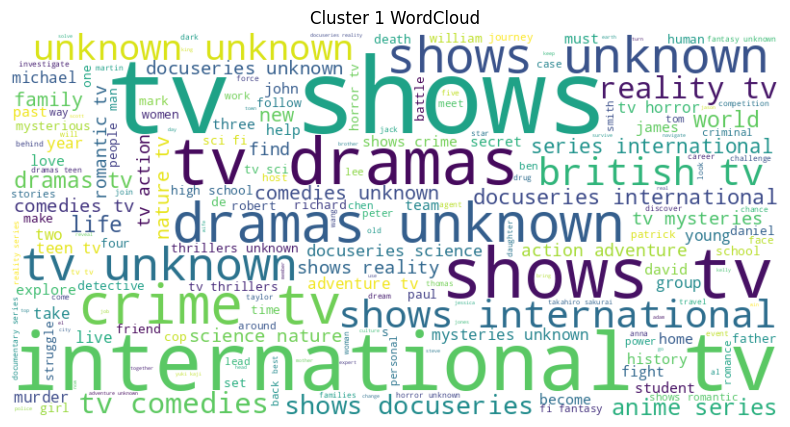

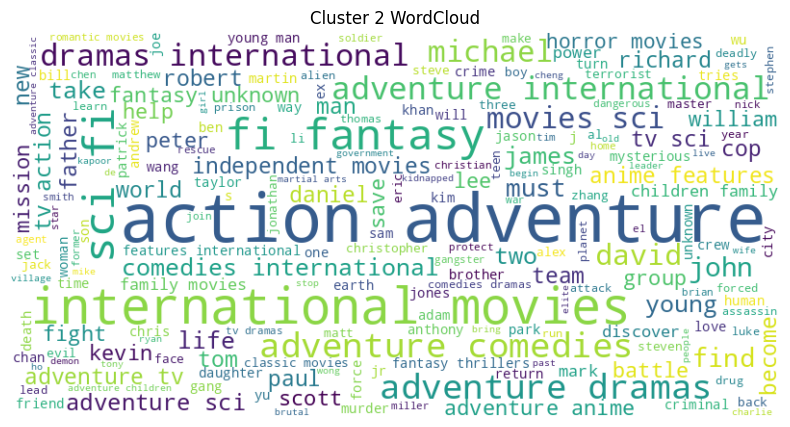

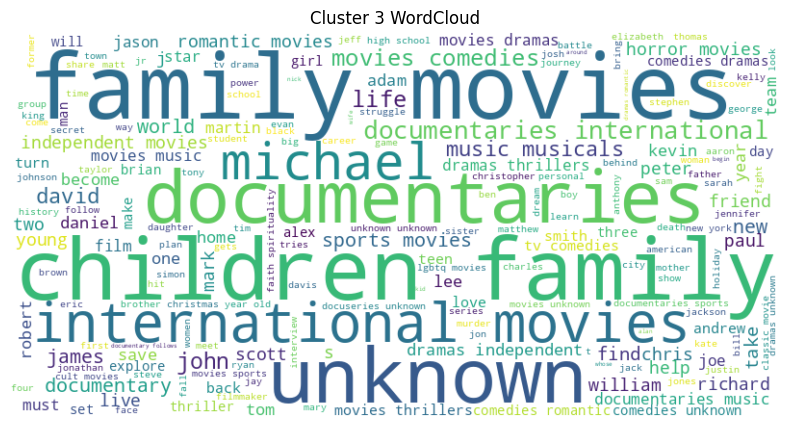

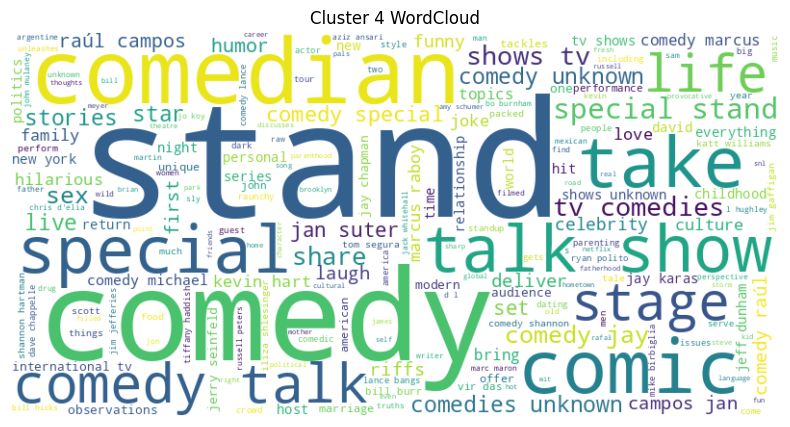

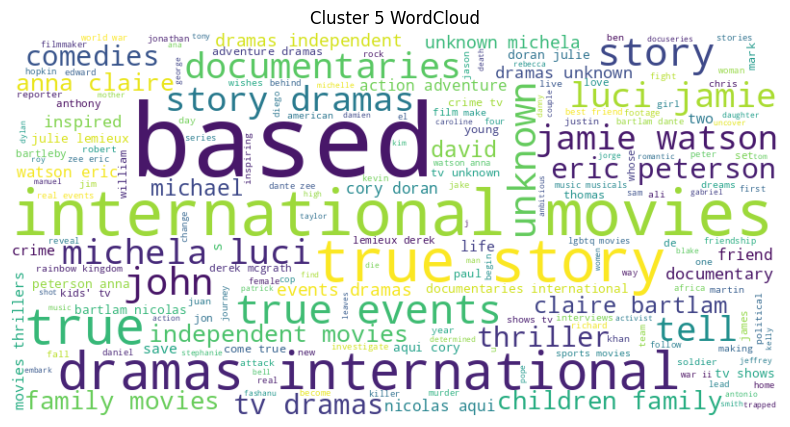

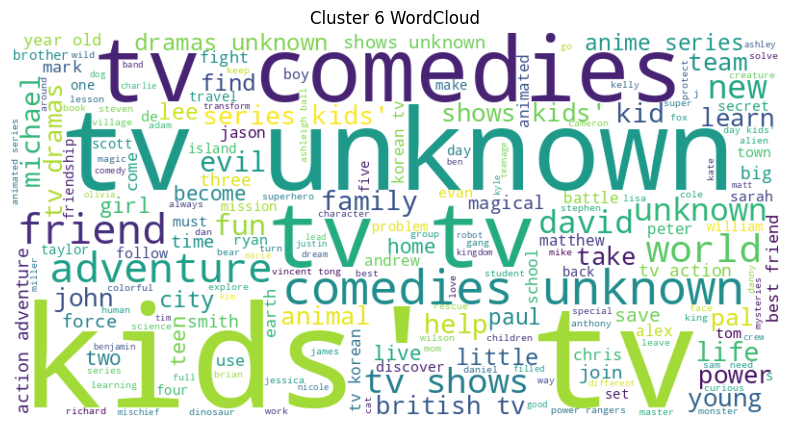

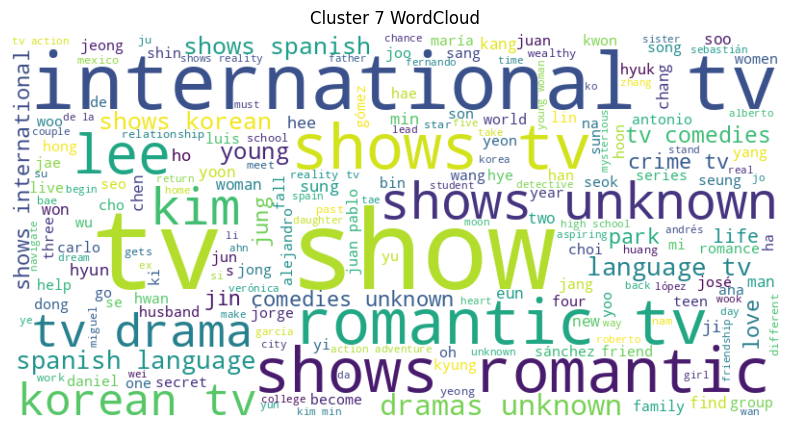

In [47]:

for i in range(8):
    text = " ".join(df[df['cluster_kmeans']==i]['combined_features'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {i} WordCloud")
    plt.show()

In [48]:
cosine_sim = cosine_similarity(X)

indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def recommend(title, n=5):
    title = title.lower()

    if title not in indices:
       return "Title not found"

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    movie_indices = [i[0] for i in sim_scores]
    return df[['title','listed_in']].iloc[movie_indices]

# Example
recommend("inception")


title  \
562                      apollo 18   
957     black mirror: bandersnatch   
1851  dragonheart: a new beginning   
44                        æon flux   
3031               into the forest   

                                           listed_in  
562       horror movies, sci-fi & fantasy, thrillers  
957   dramas, international movies, sci-fi & fantasy  
1851            action & adventure, sci-fi & fantasy  
44              action & adventure, sci-fi & fantasy  
3031  dramas, international movies, sci-fi & fantasy

In [49]:
!git init


Reinitialized existing Git repository in /content/.git/


In [60]:
!mkdir -p data notebooks src models reports


In [61]:
!ls


data  models  notebooks  reports  src


In [62]:
!ls -R



.:
data  models  notebooks  reports  src

./data:
netflix_titles.csv

./models:

./notebooks:

./reports:

./src:


In [63]:
from google.colab import files
files.upload()


Saving NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv to NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv


{'NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv': b'show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description\r\ns1,TV Show,3%,,"Jo\xc3\xa3o Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zez\xc3\xa9 Motta, Celso Frateschi",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."\r\ns2,Movie,7:19,Jorge Michel Grau,"Demi\xc3\xa1n Bichir, H\xc3\xa9ctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."\r\ns3,Movie,23:59,

In [64]:
!ls



 data	 'NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv'   reports
 models   notebooks						        src


In [65]:
!mv "NETFLIX MOVIES AND TV SHOWS CLUSTERING (1) (1) (2) (2).csv" data/netflix_titles.csv


In [66]:
!ls -R


.:
data  models  notebooks  reports  src

./data:
netflix_titles.csv

./models:

./notebooks:

./reports:

./src:


In [ ]:
import json
from google.colab import _message
from nbconvert import PythonExporter


nb_dict = _message.blocking_request("get_ipynb", timeout_sec=30)


nb_content = nb_dict["ipynb"]


notebook_path = "notebooks/netflix-content-clustering.ipynb"

with open(notebook_path, "w", encoding="utf-8") as f:
    json.dump(nb_content, f)

print("Notebook saved inside notebooks/")


exporter = PythonExporter()
body, _ = exporter.from_filename(notebook_path)

with open("src/netflix_project.py", "w", encoding="utf-8") as f:
    f.write(body)

print("Python script saved inside src/")


In [69]:
!jupyter nbconvert --to script *.ipynb


[NbConvertApp] WARNING | pattern '*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute t

In [71]:
!ls /content/drive/MyDrive



ls: cannot access '/content/drive/MyDrive': No such file or directory
